In [13]:
from bsf_beios.bsf_to_beios import BsfInfo, parse_bsf, convert_bsf
from mitie import *
import os

In [2]:

dev_files, test_files = [], []
container = dev_files
with open('../doc/dev-test-split.txt', 'r') as f:
    for ln in f:
        ln = ln.strip()
        if ln == 'DEV':
            container = dev_files
        elif ln == 'TEST':
            container = test_files
        elif ln == '':
            pass
        else:
            container.append(ln)
            
print('DEV')
print(dev_files)
print('TEST')
print(test_files)

DEV
['A_Biznes_Morozovskyi_Osoblyvosti_natsionalnoyi_vidpovidalnosti_2018.tok', 'A_Boryspilska_RDA_Osvita_Boryspilshchyny_biudzet_2017(ne_ZMI).tok', 'A_Doba_Bilous_Proyshov_oblasnyi_chempionat_z_boyovoho_hopaka_2012(4).tok', 'A_Dzerkalo_Kolomyyi_BF_Pokuttya_vyplatyv_zarplatnyu_2016(5).tok', "A_Dzerkalo_Kolomyyi_Vasyl'_Nahirnyi_prezentuvav_knyzhku_2015(5).tok", 'A_Halytska_Prosvita_Zorina_Zakokhanyi_u_skrypku_2011(5).tok', 'A_Halytskyi_korespondent_Fedoliak_Baseyn_peretikaye_do_hromady_2017(4).tok', 'A_Khreshchatyk_Zaretska_Misto_komfortne_dlia_kozhnoho_2014(5).tok', 'A_Kontrapunkt_Dudko_quintet_2011(4).tok', 'A_Kozatska_varta_Krasovskyi_Promyslovist_Zaporozkoyi_Sichi_2013(4).tok', 'A_Kozatska_varta_Magrytska_2_Viyna_pamiatnykiv_na_Luhanshchyni_2013(5).tok', 'A_Kozatska_varta_Magrytska_3_Viyna_pamiatnykiv_na_Luhanshchyni_2013(5).tok', 'A_Kraina_Zhyty_inodi_buvaye_tak_soromno,_shcho_chesnishe_–_vmerty_2014(4).tok', 'A_Krymska_svitlytsia_Khomenko_Kvitka_lomykamin_2011(5).tok', 'A_Krymska_

In [19]:
def read_bsf_data(f_name):
    base_path = '../data/'
    path = os.path.join('..', 'data', f_name)
    # read ann
    with open (path + '.ann', 'r') as f:
        annotations = f.read()
    # read tokens
    with open (path + '.txt', 'r') as f:
        tok_txt = f.read()
    
#     tokens = tok_txt.split()
    
    return (tok_txt, annotations)

In [76]:

samples = []
for f_name in dev_files:

    annotations, tok_txt = read_bsf_data(f_name)
    tokens = tok_txt.split()
    annotations = parse_bsf(annotations)
#     print(annotations)
#     print(tokens)
    
    # convert char offset to token offset
    tok_ann = []
    tok_idx = 0

    ann: BsfInfo
    for ann in annotations:
        tok_start = 0
        in_token = False
        for i in range(tok_idx, len(tokens)):
            tok_idx = i + 1            
            if not in_token and ann.token.startswith(tokens[i]):
                tok_start = i
                tok_end = i + 1
                in_token = (len(ann.token) != len(tokens[i]))

                if len(ann.token) == len(tokens[i]):
                    break
            elif in_token and ann.token.endswith(tokens[i]):
                tok_end = i+1
                in_token = False
                break
        tok_ann.append(BsfInfo(ann.id, ann.tag, tok_start, tok_end, ann.token))
        
#     print(tok_ann)
        
    sample = ner_training_instance(tokens)
    for t_ann in tok_ann:
        sample.add_entity(xrange(t_ann.start_idx, t_ann.end_idx), t_ann.tag)
    samples.append(sample)
        
print(f'Samples {len(samples)}')

Samples 182


In [ ]:
trainer = ner_trainer("../../artifacts/mitie/total_word_feature_extractor.dat")

for s in samples:
    trainer.add(s)

trainer.num_threads = 4

# This function does the work of training.  Note that it can take a long time to run
# when using larger training datasets.  So be patient.
ner = trainer.train()

# Now that training is done we can save the ner object to disk like so.  This will
# allow you to load the model back in using a statement like:
#   ner = named_entity_extractor("new_ner_model.dat").
ner.save_to_disk("../../artifacts/mitie/ner_model.dat")

# But now let's try out the ner object.  It was only trained on a small dataset but it
# has still learned a little.  So let's give it a whirl.  But first, print a list of
# possible tags.  In this case, it is just "person" and "org".
print ("tags:", ner.get_possible_ner_tags())

Training to recognize 4 labels: 'ORG', 'PERS', 'MISC', 'LOC'
Part I: train segmenter
words in dictionary: 49649
num features: 271
now do training
C:           20
epsilon:     0.01
num threads: 4
cache size:  5
max iterations: 2000
loss per missed segment:  3
C: 20   loss: 3 	0.591648


# MITIE: Results of the model

In [99]:
# read test data to iob format labels
y_test_true = []
x_test = []
for f_name in test_files:
#     print(f_name)
    txt, ann = read_bsf_data(f_name)
    iob_lst = convert_bsf(txt, ann, 'iob').split('\n')
#     print(iob)
    iob = [tok.split()[1] for tok in iob_lst if len(tok.split()) == 2]
#     print(iob)
    y_test_true.append(iob)
    x_test.append(txt)
    


In [102]:
model = named_entity_extractor('../../artifacts/mitie/ner_model_uber.dat')

ent_lst = []
for x in x_test:

    entities = model.extract_entities(x.split()) # (range, tag, score)
    ent_lst.append(entities)
    
#convert to iob
y_res = []
for xi in range(len(x_test)):
    x = x_test[xi]
    ents = ent_lst[xi]
#     print(ents)
    
    tokens = x.split()
#     print(len(tokens))
    ent_i = 0
    iob = []
#     print(tokens)
    for ti in range(len(tokens)):
        if ent_i >= len(ents):
            iob.append('O')
            continue
#         print(ent_i)
#         print(f'{ents[ent_i]}= {ents[ent_i][0][0]}-{ents[ent_i][0][1]}, {ents[ent_i][1]}')
        rng, tag, _ = ents[ent_i]
        start_i, end_i = rng.start, rng.stop
        if ent_i >= len(ents) or ti < start_i:
            iob.append('O')
        elif ti == start_i:
            iob.append('B-' + tag)
            if start_i == end_i - 1: 
                ent_i = ent_i + 1
        elif ti > start_i and ti < end_i:
            iob.append('I-' + tag)
            if ti == end_i - 1:
                ent_i = ent_i + 1
#     print(len(iob))
#     print(iob)
    y_res.extend(iob)
# print(y_res)

In [107]:
# print([len(y) for y in y_test_true])
# print([len(y) for y in y_res])
labels = model.get_possible_ner_tags()
print(labels)

['ORG', 'PERS', 'MISC', 'LOC']


In [110]:
from sklearn.metrics import classification_report
# y_true = ['o', 'b', 'i', 'i', 'o']
# y_pred = ['o', 'o', 'b', 'i', 'o']
# >>> target_names = ['class 0', 'class 1', 'class 2']
y_test_true_flat = [item for sublist in y_test_true for item in sublist]
# y_res = [item for sublist in y_res for item in sublist]
# labels = model.get_possible_ner_tags()
# sorted_labels = sorted(labels,key=lambda name: (name[1:], name[0]))
print('Classification report: MITIE \nwith feature extractor trained on uber corpus')
print(classification_report(y_test_true_flat, y_res))

Classification report: MITIE 
with feature extractor trained on uber corpus
              precision    recall  f1-score   support

       B-LOC       0.66      0.79      0.72       401
      B-MISC       0.44      0.20      0.27       240
       B-ORG       0.41      0.26      0.32       261
      B-PERS       0.87      0.79      0.83      1678
       I-LOC       0.46      0.39      0.42       117
      I-MISC       0.40      0.07      0.12       478
       I-ORG       0.51      0.21      0.29       360
      I-PERS       0.88      0.86      0.87       457
           O       0.98      1.00      0.99     74598

    accuracy                           0.97     78590
   macro avg       0.62      0.51      0.54     78590
weighted avg       0.97      0.97      0.97     78590



# Stanza

## Basic data analysis. How classes are balanced.

In [77]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

dev_bsf = []

files = dev_files
for f_name in files:
    with open ('../data/' + f_name + '.ann', 'r') as f:
        dev_bsf.extend(parse_bsf(f.read()))
        
categories = [c.tag for c in dev_bsf]
dev_cnt = Counter(categories)
print('Dev categories:')
print(dev_cnt)
print(f'Dev files: {len(dev_files)}')


#test
test_bsf = []

files = test_files
for f_name in files:
    with open ('../data/' + f_name + '.ann', 'r') as f:
        test_bsf.extend(parse_bsf(f.read()))
        
test_cat = [c.tag for c in test_bsf]
test_cnt = Counter(test_cat)
print('Test categories:')
print(test_cnt)
print(f'Test files: {len(test_files)}')

Dev categories:
Counter({'PERS': 2709, 'LOC': 1213, 'ORG': 519, 'MISC': 420})
Dev files: 182
Test categories:
Counter({'PERS': 1678, 'LOC': 401, 'ORG': 261, 'MISC': 240})
Test files: 80


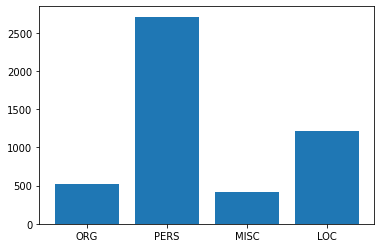

In [51]:
# list(dev_cnt)
vals = dev_cnt.values()
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), list(dev_cnt))
plt.show()

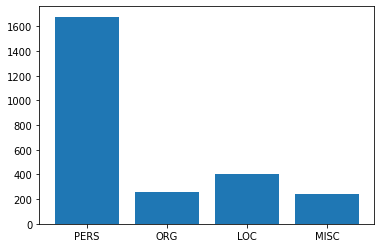

In [52]:

vals = test_cnt.values()
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), list(test_cnt))
plt.show()